## 환경 설정 및 데이터 불러오기

In [1]:
%pip install pandas
%pip install datasets
%pip install transformers
%pip install torch
%pip install evaluate
%pip install 'transformers[torch]'
%pip install accelerate
%pip install tf-keras
%pip install wordcloud
%pip install nltk
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
# # pip freeze

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer # 토크나이저, GPU
from transformers import AutoModelForSequenceClassification # 모델 로드
from transformers import Trainer, TrainingArguments # 모델 학습
from transformers import AdamW # 옵티마이저
from torch.nn import CrossEntropyLoss # 손실 함수
from transformers import pipeline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import torch
from torch.utils.data import DataLoader
import evaluate

from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# # NLTK 데이터 다운로드 경로 지정
nltk_data_dir = '/data/ephemeral/home/imdb/imdbenv/nltk_data'
nltk.data.path = []
tokenizers_dir = os.path.join(nltk_data_dir, 'tokenizers')

nltk.data.path.append(nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)  # 최우선 검색 경로로 추가

# 필요한 NLTK 데이터 다운로드
try:
    nltk.download('punkt', download_dir=nltk_data_dir)
    nltk.download('punkt_tab', download_dir=nltk_data_dir)
    nltk.download('averaged_perceptron_tagger', download_dir=nltk_data_dir)
    nltk.download('maxent_ne_chunker', download_dir=nltk_data_dir)
    nltk.download('words', download_dir=nltk_data_dir)
    nltk.download('stopwords', download_dir=nltk_data_dir)
    nltk.download('wordnet', download_dir=nltk_data_dir)
    
    print("NLTK 데이터 다운로드 완료!")
except Exception as e:
    print(f"다운로드 중 에러 발생: {e}")

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
plt.rcParams['font.family'] = 'NanumGothic'


[nltk_data] Downloading package punkt to
[nltk_data]     /data/ephemeral/home/imdb/imdbenv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /data/ephemeral/home/imdb/imdbenv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /data/ephemeral/home/imdb/imdbenv/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /data/ephemeral/home/imdb/imdbenv/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /data/ephemeral/home/imdb/imdbenv/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /data/ephemeral/home/imdb/imdbenv/nltk_data...
[nltk_data]   Package st

NLTK 데이터 다운로드 완료!


In [4]:
import nltk
print(nltk.data.path)

['/data/ephemeral/home/imdb/imdbenv/nltk_data', '/data/ephemeral/home/imdb/imdbenv/nltk_data']


In [5]:
data = pd.read_csv('IMDB_Dataset.csv')

In [6]:
data

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## 1. EDA

In [7]:
print(data.head())
print("\n")
print(data.info())
print("\n")
print(data.describe())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                               

In [8]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

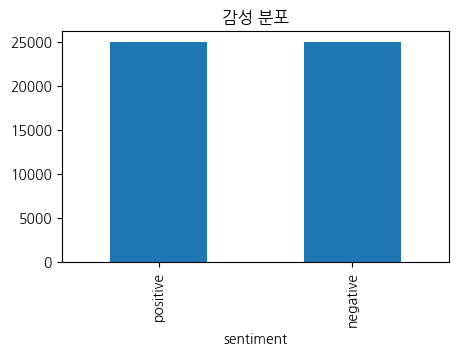

In [9]:
# 감성 분포
plt.figure(figsize=(5, 3))
data['sentiment'].value_counts().plot(kind='bar')
plt.title("감성 분포")
plt.show()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


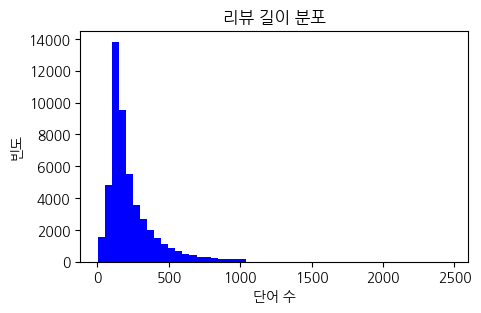

In [10]:
# 텍스트 길이 계산
data['review_length'] = data['review'].apply(lambda x: len(x.split()))

# 리뷰 길이 통계
print(data['review_length'].describe())

# 리뷰 길이 분포
plt.figure(figsize=(5, 3))
plt.hist(data['review_length'], bins=50, color='blue')
plt.title('리뷰 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

In [11]:
positive_reviews = data[data['sentiment'] == 'positive']['review']
negative_reviews = data[data['sentiment'] == 'negative']['review']

In [12]:
# Tokenize and count words
positive_words = Counter([word for review in positive_reviews for word in word_tokenize(review.lower())])
negative_words = Counter([word for review in negative_reviews for word in word_tokenize(review.lower())])

# Most common positive words
print(positive_words.most_common(10))

# Most common negative words
print(negative_words.most_common(10))

[('the', 339238), (',', 282003), ('.', 230821), ('and', 175937), ('a', 163442), ('of', 151671), ('to', 130801), ('is', 114193), ('in', 98409), ('/', 98198)]
[('the', 324975), (',', 262027), ('.', 233567), ('a', 157812), ('and', 147139), ('of', 136855), ('to', 136232), ('/', 104257), ('>', 104177), ('<', 104100)]


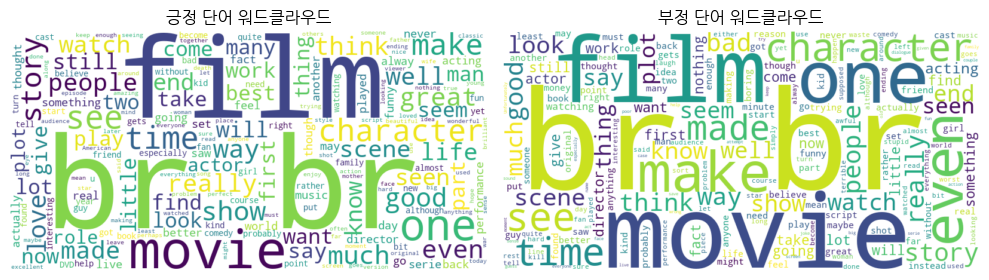

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
# 긍정 단어 워드클라우드
positive_text = ' '.join(positive_reviews)
positive_wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(positive_text)

# 긍정 단어 워드클라우드 시각화
ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.axis('off')
ax1.set_title('긍정 단어 워드클라우드')

# 부정 단어 워드클라우드
negative_text = ' '.join(negative_reviews)
negative_wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white'
).generate(negative_text)

# 부정 단어 워드클라우드 시각화
ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.axis('off')
ax2.set_title('부정 단어 워드클라우드')
plt.tight_layout()
plt.show()

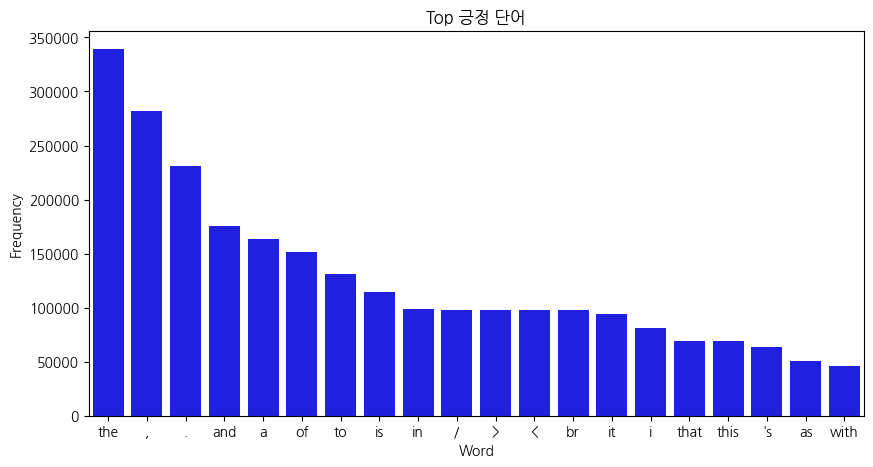

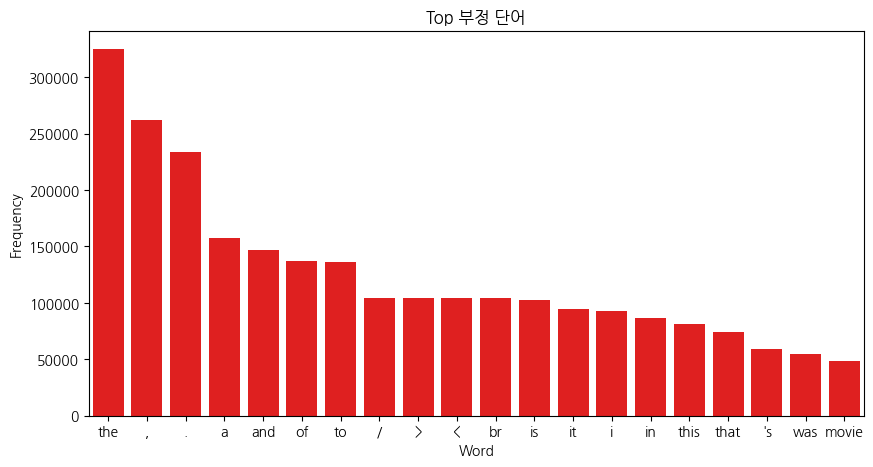

In [14]:
# 감성별 단어 사용 분석
positive_specific = positive_words.most_common(20)
negative_specific = negative_words.most_common(20)

# DataFrame으로 변환
positive_df = pd.DataFrame(positive_specific, columns=['Word', 'Frequency'])
negative_df = pd.DataFrame(negative_specific, columns=['Word', 'Frequency'])

# 긍정 및 부정 단어 사용 시각화
plt.figure(figsize=(10, 5))
sns.barplot(data=positive_df, x='Word', y='Frequency', color='blue')
plt.title('Top 긍정 단어')
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=negative_df, x='Word', y='Frequency', color='red')
plt.title('Top 부정 단어')
plt.show()

## 2. 데이터 전처리

#### train test 데이터 분리

In [15]:
# dataset 형태로 변환
dataset = Dataset.from_pandas(data)

# train, test 데이터 분리
dataset = dataset.train_test_split(test_size=0.3)
train = dataset['train']
test = dataset['test']


In [16]:
train[10], test[10]


({'review': 'After Chicago, I was beginning to lose all respect for Richard Gere and then along came The Flock. There\'s just so far a nice smile and a couple of stock facial gestures can get you, but he proved to me that he\'s finally gotten hold of his craft and can act with the best of them. Clare Danes was also super as his "trainee/replacement". Some have suggested there was too much unnecessary violence, but I don\'t see it that way. Nothing I saw detracted from the power of this film. I was really shocked I hadn\'t heard of it being released in theaters and came across it at Blockbuster instead. Really an exceptional film with just the right blend of action, suspense, thrills, and social consciousness. As good as 7even? Well, maybe. And you\'ll see better acting out of Gere than anyone\'s ever gotten out of Pitt.',
  'sentiment': 'positive',
  'review_length': 147},
 {'review': "Drew Barrymore keeps seeing her alter-ego all over town and it's really starting to become a pain in 

#### 텍스트 정제

In [20]:
# 텍스트 정제 함수 정의
def clean_text(text): 
    text = re.sub(r'<.*?>', '', text)  # HTML 태그 제거
    text = re.sub(r'[^\w\s]', '', text)  # 특수문자 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.lower()  # 소문자로 변환
    text = text.strip()  # 문자열 양쪽 공백 제거
    text = text.replace('br', '')  # 'br' 태그 제거
        
    return text

# Dataset에 새로운 컬럼 추가하는 함수
def add_cleaned_review(dt):
    return {
        'cleaned_review': clean_text(dt['review']),
        **dt  # 기존 컬럼들 유지
    }

# train과 test 각각에 대해 적용
train = train.map(add_cleaned_review)
test = test.map(add_cleaned_review)

# 결과 확인
print("Training example:")



Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Training example:


In [22]:
train[10], test[10]


({'review': 'After Chicago, I was beginning to lose all respect for Richard Gere and then along came The Flock. There\'s just so far a nice smile and a couple of stock facial gestures can get you, but he proved to me that he\'s finally gotten hold of his craft and can act with the best of them. Clare Danes was also super as his "trainee/replacement". Some have suggested there was too much unnecessary violence, but I don\'t see it that way. Nothing I saw detracted from the power of this film. I was really shocked I hadn\'t heard of it being released in theaters and came across it at Blockbuster instead. Really an exceptional film with just the right blend of action, suspense, thrills, and social consciousness. As good as 7even? Well, maybe. And you\'ll see better acting out of Gere than anyone\'s ever gotten out of Pitt.',
  'sentiment': 'positive',
  'review_length': 147,
  'cleaned_review': 'after chicago i was beginning to lose all respect for richard gere and then along came the flo

#### 토큰화

In [23]:
# (2) Hugging/BERT 토크나이저 설정 및 적용
# model_name = "bert-base-uncased"    
model_name = "albert-base-v2"
# model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

def bert_tokenizer(dt):
    # BERT 토큰화 및 새로운 컬럼 추가
    bert_tokens = tokenizer(
        dt['cleaned_review'],
        padding='max_length',           # 짧은 텍스트를 0으로 채움
        truncation=True,                # 긴 텍스트를 잘라내 최대 토큰 수에 맞춤
        max_length=300                   # 최대 토큰 수
    )
    return {
        'input_ids': bert_tokens['input_ids'],                  # input_ids: 토큰화된 텍스트 ID
        'attention_mask': bert_tokens['attention_mask'],        # attention_mask: 패딩 처리 구분
        **dt
    }

# train과 test에 적용
train = train.map(bert_tokenizer)
test = test.map(bert_tokenizer)

train[10], test[10]

Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

({'review': 'After Chicago, I was beginning to lose all respect for Richard Gere and then along came The Flock. There\'s just so far a nice smile and a couple of stock facial gestures can get you, but he proved to me that he\'s finally gotten hold of his craft and can act with the best of them. Clare Danes was also super as his "trainee/replacement". Some have suggested there was too much unnecessary violence, but I don\'t see it that way. Nothing I saw detracted from the power of this film. I was really shocked I hadn\'t heard of it being released in theaters and came across it at Blockbuster instead. Really an exceptional film with just the right blend of action, suspense, thrills, and social consciousness. As good as 7even? Well, maybe. And you\'ll see better acting out of Gere than anyone\'s ever gotten out of Pitt.',
  'sentiment': 'positive',
  'review_length': 147,
  'cleaned_review': 'after chicago i was beginning to lose all respect for richard gere and then along came the flo

## 3. 모델

#### 모델 로드 및 설정

In [25]:
label2id = {'negative':0, 'positive':1}
train = train.map(lambda x: {'label': label2id[x['sentiment']]})
test = test.map(lambda x: {'label': label2id[x['sentiment']]})


Map:   0%|          | 0/35000 [00:00<?, ? examples/s]

Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [26]:
id2label = {0:'negative', 1:'positive'}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=len(label2id),       # 레이블 갯수
    label2id=label2id,              # 레이블 문자열 데이터를 숫자로 매핑 딕셔너리
    id2label=id2label               # 숫자를 레이블 문자열로 매핑 딕셔너리
)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# GPU 설정
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [27]:
import evaluate
import numpy as np
# Hugging Face evaluate 라이브러리에서 accuracy(정확도) 메트릭을 불러옵니다.
accuracy = evaluate.load('accuracy')
# compute_metrics 함수는 모델의 예측값과 실제 레이블을 받아 정확도를 계산합니다.
def compute_metrics(eval_pred):  #평가 지표 계산 함수 정의
    # eval_pred는 모델의 예측값과 실제 레이블을 포함하는 튜플입니다.
    predictions, labels = eval_pred  # predictions: 모델이 예측한 값, labels: 실제 정답 레이블
    
    # predictions는 모델이 출력한 확률값 배열이며, 가장 높은 확률을 가진 클래스를 선택합니다.
    # np.argmax는 각 샘플에 대해 가장 높은 확률값을 가진 클래스의 인덱스를 반환합니다.
    predictions = np.argmax(predictions, axis=1)  # 각 샘플별로 가장 높은 확률을 가진 클래스 선택
    
    # accuracy.compute는 예측값(predictions)과 실제값(labels)을 비교하여 정확도를 계산합니다.
    # predictions: 모델이 예측한 클래스, references=labels: 실제 정답 클래스
    return accuracy.compute(predictions=predictions, references=labels) #예측값과 실제값 비교 후 정확도 계산

In [30]:
#  학습 및 평가 설정
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir='train_dir', # 학습 결과를 저장할 디렉토리
    overwrite_output_dir=True,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=32, # 각 디바이스당 학습 배치 크기
    per_device_eval_batch_size=32, # 각 디바이스당 평가 배치 크기
    eval_strategy='epoch' # 매 에포크마다 평가
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train,
    eval_dataset=test,
    compute_metrics=compute_metrics, # 평가 지표를 계산하 함수
    tokenizer=tokenizer # 텍스트를 토큰으로 변환하는 도구
)

/tmp/ipykernel_1236643/4187886994.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


#### 모델 학습 및 평가

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.209800,0.208901,0.926733
2,0.144700,0.177285,0.934000
3,0.077700,0.262291,0.935000


TrainOutput(global_step=3282, training_loss=0.15436891257072788, metrics={'train_runtime': 1560.5471, 'train_samples_per_second': 67.284, 'train_steps_per_second': 2.103, 'total_flos': 1470293370000000.0, 'train_loss': 0.15436891257072788, 'epoch': 3.0})

In [32]:
trainer.evaluate()  # 데이터 정확도 확인으로 평가 

{'eval_loss': 0.26229140162467957,
 'eval_accuracy': 0.935,
 'eval_runtime': 70.3555,
 'eval_samples_per_second': 213.203,
 'eval_steps_per_second': 6.666,
 'epoch': 3.0}

#### 마무리

##### (2)

In [33]:
# 모델 저장
trainer.save_model('albertbasev2_sentiment_analysis')  # 옆에 새로운 디렉토리에 모델이 저장될 것임

In [38]:
# 감정 분석 파이프라인 생성
sentiment_analyzer = pipeline(task='sentiment-analysis', model='albertbasev2_sentiment_analysis', device=device)
sentiment_analyzer

In [45]:
# 새로운 데이터 예측
data = ['This movie was fantastic! I really enjoyed it', 'i would hate to not watch this movie']
sentiment_analyzer(data)

[{'label': 'positive', 'score': 0.9948849081993103},
 {'label': 'negative', 'score': 0.9260485768318176}]